## Exploratory data analysis: Consolidation

In [1]:
# Preparations
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load clean csv files
# Cleaned datasets are located in the /data/dev folder
df_isa = pd.read_csv('../data/dev/ISA.csv', index_col = 'Date')
df_celsia = pd.read_csv('../data/dev/CELSIA.csv', index_col = 'Date')
df_ecopetrol = pd.read_csv('../data/dev/Ecopetrol.csv', index_col = 'Date')
df_petroleo = pd.read_csv('../data/dev/Petroleo WTI.csv', index_col = 'Date')
df_embi = pd.read_csv('../data/dev/EMBI.csv', index_col = 'Date')
df_geb = pd.read_csv('../data/dev/Grupo Energía de Bogotá.csv', index_col = 'Date')
df_colcap = pd.read_csv('../data/dev/COLCAP.csv', index_col = 'Date')
df_usd = pd.read_csv('../data/dev/USD.csv', index_col = 'Date')
df_tesone = pd.read_csv('../data/dev/TES 1 año.csv', index_col = 'Date')
df_tesfive = pd.read_csv('../data/dev/TES 5 años.csv', index_col = 'Date')
df_tesfifteen =  pd.read_csv('../data/dev/TES 15 años.csv', index_col = 'Date')

In [3]:
df_isa.index = pd.to_datetime(df_isa.index)
df_celsia.index = pd.to_datetime(df_celsia.index)
df_ecopetrol.index = pd.to_datetime(df_ecopetrol.index)
df_petroleo.index = pd.to_datetime(df_petroleo.index)
df_embi.index = pd.to_datetime(df_embi.index)
df_geb.index = pd.to_datetime(df_geb.index)
df_colcap.index = pd.to_datetime(df_colcap.index)
df_usd.index = pd.to_datetime(df_usd.index)
df_tesone.index = pd.to_datetime(df_tesone.index)
df_tesfive.index = pd.to_datetime(df_tesfive.index)
df_tesfifteen.index =  pd.to_datetime(df_tesfifteen.index)

Add all missing dates in the ISA dataset to combine the most information from other datasets

In [4]:
idx = pd.date_range(df_isa.index.min(), df_isa.index.max())
df_isa = df_isa.reindex(idx, fill_value=np.nan)

In [5]:
# Combine all into one dataframe; preserve every entry
lst_df = [df_isa, df_celsia, df_ecopetrol, df_petroleo, df_embi, df_geb, df_usd, df_tesone, df_tesfive, df_tesfifteen, df_colcap];
df_integrated = pd.concat(lst_df,
                          keys = ['isa', 'celsia', 'ecopetrol', 'petroleo', 'embi', 'geb', 'usd', 'tesone', 'tesfive', 'tesfifteen', 'colcap'],
                          axis = 1,
                          join = 'outer'
                         )
df_integrated.dropna(axis = 0, subset = [('isa', 'Instrument Name')], inplace=True)
df_integrated.head()

isa                                                \
           Instrument Name    Year Month  Day    High     Low        Mid   
2003-07-03             ISA  2003.0   7.0  3.0  1041.0  1038.0  1039.8528   
2003-07-04             ISA  2003.0   7.0  4.0  1040.0  1037.0  1039.5585   
2003-07-07             ISA  2003.0   7.0  7.0  1040.0  1039.0  1039.7341   
2003-07-08             ISA  2003.0   7.0  8.0  1030.0  1015.0  1022.1858   
2003-07-09             ISA  2003.0   7.0  9.0  1020.0  1010.0  1012.2169   

                                                ... tesfifteen  \
             Close Close Previous       Volume  ...  Variation   
2003-07-03  1041.0            NaN  153392851.0  ...        NaN   
2003-07-04  1040.0         1041.0  252284203.0  ...        NaN   
2003-07-07  1040.0         1040.0  154115627.0  ...        NaN   
2003-07-08  1018.0         1040.0  609217622.0  ...        NaN   
2003-07-09  1013.0         1018.0  173275330.0  ...        NaN   

                    colcap                                               \
           Instrument Name Year Month Day High Low Close Close Previous   
2003-07-03             NaN  NaN   NaN NaN  NaN NaN   NaN            NaN   
2003-07-04             NaN  NaN   NaN NaN  NaN NaN   NaN            NaN   
2003-07-07             NaN  NaN   NaN NaN  NaN NaN   NaN            NaN   
2003-07-08             NaN  NaN   NaN NaN  NaN NaN   NaN            NaN   
2003-07-09             NaN  NaN   NaN NaN  NaN NaN   NaN            NaN   

                      
           Variation  
2003-07-03       NaN  
2003-07-04       NaN  
2003-07-07       NaN  
2003-07-08       NaN  
2003-07-09       NaN  

[5 rows x 111 columns]

In [6]:
#Imputing values by columns
def missing_estimation (df, group, columns = [], hasVar = False):
    imp = IterativeImputer(max_iter=20, random_state=0)
    imp.fit(df[group][columns])

    X_test = df[group][columns]
    aux = pd.DataFrame(
        imp.transform(X_test),
        columns = columns,
        index = df.index
    )
    if hasVar:
        aux['Variation'] = aux['Close'].astype('int64').pct_change()*100.0
    aux['Instrument Name'] = df[group]['Instrument Name'][0]
    aux['Year'] = pd.to_datetime(aux.index).year
    aux['Month'] = pd.to_datetime(aux.index).month
    aux['Day'] = pd.to_datetime(aux.index).day
    if 'Close' in aux.columns:
        aux.columns
        aux['Close previous'] = aux['Close'].shift(1)
    aux.index = pd.to_datetime(aux.index)
    
    return aux

In [7]:
#Cleaning first missing data
valid = "";
print(df_integrated.shape)
for i in df_integrated.index:
    if not df_integrated.loc[i].isnull().values.any():
        valid = i
        break;
df_integrated = df_integrated.loc[valid:]
df_integrated.shape

(4596, 111)


(2459, 111)

In [8]:
#Analyzing values
df_integrated[['celsia', 'ecopetrol', 'petroleo']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2459 entries, 2012-04-30 to 2022-07-01
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (celsia, Instrument Name)     2417 non-null   object 
 1   (celsia, Year)                2417 non-null   float64
 2   (celsia, Month)               2417 non-null   float64
 3   (celsia, Day)                 2417 non-null   float64
 4   (celsia, Open)                2417 non-null   float64
 5   (celsia, High)                2417 non-null   float64
 6   (celsia, Low)                 2417 non-null   float64
 7   (celsia, Close)               2417 non-null   float64
 8   (celsia, Close previous)      2417 non-null   float64
 9   (celsia, Volume)              2417 non-null   float64
 10  (celsia, Variation)           2417 non-null   float64
 11  (ecopetrol, Instrument Name)  2430 non-null   object 
 12  (ecopetrol, Year)             2430 non-null 

In [9]:
#Aplyig missing_estimation function and replacing datasets
df_isa = df_integrated['isa']
df_celsia = missing_estimation(df_integrated, 'celsia', ['Open', 'High', 'Low', 'Close', 'Volume'], True)
df_ecopetrol = missing_estimation(df_integrated, 'ecopetrol', ['Open', 'High', 'Low', 'Close', 'Volume'], True)
df_petroleo = missing_estimation(df_integrated, 'petroleo', ['Open', 'High', 'Low', 'Close', 'Volume'], True)
df_embi = missing_estimation(df_integrated, 'embi', ['BPS', 'Percentage Terms'])
df_geb = missing_estimation(df_integrated, 'geb', ['Open', 'High', 'Low', 'Close', 'Volume'], True)
df_usd = missing_estimation(df_integrated, 'usd', ['Open', 'High', 'Low', 'Close'], True)
df_tesone = missing_estimation(df_integrated, 'tesone', ['High', 'Low', 'Close'], True)
df_tesfive = missing_estimation(df_integrated, 'tesfive', ['Open', 'High', 'Low', 'Close'], True)
df_tesfifteen = missing_estimation(df_integrated, 'tesfifteen', ['High', 'Low', 'Close'], True)
df_colcap = missing_estimation(df_integrated, 'colcap', ['High', 'Low', 'Close'], True)

In [10]:
#Rebuilding df_integrated 
lst_df = [df_isa, df_celsia, df_ecopetrol, df_petroleo, df_embi, df_geb, df_usd, df_tesone, df_tesfive, df_tesfifteen, df_colcap];
df_integrated = pd.concat(lst_df,
                          keys = ['isa', 'celsia', 'ecopetrol', 'petroleo', 'embi', 'geb', 'usd', 'tesone', 'tesfive', 'tesfifteen', 'colcap'],
                          axis = 1,
                          join = 'outer'
                         )
df_integrated[['celsia', 'ecopetrol', 'petroleo']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2459 entries, 2012-04-30 to 2022-07-01
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (celsia, Open)                2459 non-null   float64
 1   (celsia, High)                2459 non-null   float64
 2   (celsia, Low)                 2459 non-null   float64
 3   (celsia, Close)               2459 non-null   float64
 4   (celsia, Volume)              2459 non-null   float64
 5   (celsia, Variation)           2458 non-null   float64
 6   (celsia, Instrument Name)     2459 non-null   object 
 7   (celsia, Year)                2459 non-null   int64  
 8   (celsia, Month)               2459 non-null   int64  
 9   (celsia, Day)                 2459 non-null   int64  
 10  (celsia, Close previous)      2458 non-null   float64
 11  (ecopetrol, Open)             2459 non-null   float64
 12  (ecopetrol, High)             2459 non-null 

In [11]:
#Analizing statistics information
df_integrated.describe()

isa                                                        \
              Year        Month          Day          High           Low   
count  2459.000000  2459.000000  2459.000000   2459.000000   2459.000000   
mean   2016.924766     6.467263    15.846686  13782.053680  13460.719805   
std       2.965017     3.416332     8.755173   5612.311337   5441.798183   
min    2012.000000     1.000000     1.000000      0.000000      0.000000   
25%    2014.000000     4.000000     8.000000   9050.000000   8900.000000   
50%    2017.000000     6.000000    16.000000  12680.000000  12060.000000   
75%    2019.000000     9.000000    23.000000  18990.000000  18500.000000   
max    2022.000000    12.000000    31.000000  29250.000000  28800.000000   

                                                                             \
                Mid         Close Close Previous        Volume    Variation   
count   2459.000000   2459.000000    2458.000000  2.459000e+03  2459.000000   
mean   13636.014961  13656.323709   13648.051261  5.163094e+09     0.049428   
std     5523.566006   5524.839278    5520.065664  7.140992e+09     1.806150   
min        0.000000   5420.000000    5420.000000  0.000000e+00   -24.090000   
25%     8971.015000   8980.000000    8980.000000  1.776877e+09    -0.750000   
50%    12366.550000  12400.000000   12340.000000  3.343079e+09     0.000000   
75%    18767.140000  18790.000000   18780.000000  6.057267e+09     0.860000   
max    29091.810000  29250.000000   29250.000000  1.323960e+11    14.880000   

       ...   tesfifteen                      colcap                            \
       ...          Day Close previous         High          Low        Close   
count  ...  2459.000000    2458.000000  2459.000000  2459.000000  2459.000000   
mean   ...    15.846686       7.202185  1476.156141  1460.084751  1468.567460   
std    ...     8.755173       0.959910   184.746288   186.387542   185.600851   
min    ...     1.000000       5.129000   916.390000   880.720000   894.030000   
25%    ...     8.000000       6.680000  1335.140000  1321.025000  1329.625000   
50%    ...    16.000000       7.129000  1478.290000  1464.480000  1471.340000   
75%    ...    23.000000       7.630000  1620.295000  1602.315000  1612.835000   
max    ...    31.000000      12.085000  1895.210000  1875.010000  1889.300000   

                                                                          
         Variation         Year        Month          Day Close previous  
count  2458.000000  2459.000000  2459.000000  2459.000000    2458.000000  
mean     -0.001817  2016.924766     6.467263    15.846686    1468.567460  
std       1.105398     2.965017     3.416332     8.755173     185.638617  
min     -12.467076  2012.000000     1.000000     1.000000     894.030000  
25%      -0.452681  2014.000000     4.000000     8.000000    1329.602500  
50%       0.000000  2017.000000     6.000000    16.000000    1471.575000  
75%       0.489216  2019.000000     9.000000    23.000000    1612.942500  
max      13.326111  2022.000000    12.000000    31.000000    1889.300000  

[8 rows x 99 columns]

## Correlation matrix: ISA information

#### For the following correlation matrices, the proposed importance threshold is 0.3 in absolute value

In [12]:
df_isa.head()

,Instrument Name,Year,Month,Day,High,Low,Mid,Close,Close Previous,Volume,Variation,Absolute Variation,Quantity
2012-04-30,ISA,2012.0,4.0,30.0,11400.0,11100.0,11277.00,11400.0,11180.0,3.054284e+09,1.97,220.0,270842.0
2012-05-02,ISA,2012.0,5.0,2.0,11700.0,11280.0,11554.87,11700.0,11400.0,5.623837e+09,2.63,300.0,486707.0
2012-05-03,ISA,2012.0,5.0,3.0,11760.0,11520.0,11649.47,11760.0,11700.0,1.763461e+09,0.51,60.0,151377.0
2012-05-04,ISA,2012.0,5.0,4.0,11900.0,11700.0,11810.44,11900.0,11760.0,5.107495e+09,1.19,140.0,432456.0
2012-05-07,ISA,2012.0,5.0,7.0,11920.0,11660.0,11780.64,11740.0,11900.0,1.155810e+09,-1.34,-160.0,98111.0


<Figure size 432x288 with 0 Axes>

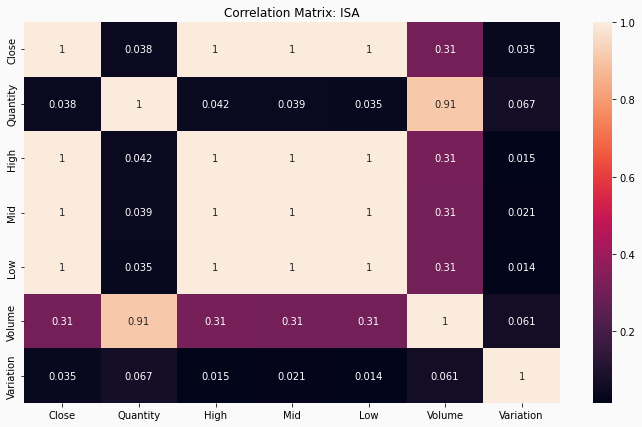

In [29]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), facecolor=(.98, .98, .98))
#sns.heatmap(df_isa[['Close', 'Quantity', 'High', 'Mid', 'Low','Volume', 'Variation']].corr(), annot=True).set(title='Correlation Matrix: ISA');
sns.heatmap(df_isa[['Close', 'Quantity', 'High', 'Mid', 'Low','Volume', 'Variation']].corr(), annot=True).set(title='Correlation Matrix: ISA');

According to the correlation matrix, the most important variables for the prediction of the closing price based only on the ISA data are:

- `High`
- `Mid`
- `Low`

However, the `Volume` could also be considered

## Correlation matrix: stocks

In [14]:
# Combine all into one dataframe; preserve every entry
lst_df = [
    df_isa[['Close']],
    df_celsia[['Open', 'High', 'Low', 'Close', 'Volume', 'Variation']],
    df_ecopetrol[['Open', 'High', 'Low', 'Close', 'Volume', 'Variation']],
    df_petroleo[['Open', 'High', 'Low', 'Close', 'Volume', 'Variation']],
    df_geb[['Open', 'High', 'Low', 'Close', 'Volume', 'Variation']],
];
df_integrated_stocks = pd.concat(lst_df,
                          keys = ['isa', 'celsia', 'ecopetrol', 'petroleo', 'geb'],
                          axis = 1,
                          join = 'outer'
                         )
df_integrated_stocks.head()

isa  celsia                                              \
              Close    Open    High     Low   Close    Volume Variation   
2012-04-30  11400.0  4770.0  4780.0  4750.0  4770.0  327900.0       NaN   
2012-05-02  11700.0  4775.0  4990.0  4775.0  4980.0  802820.0  4.402516   
2012-05-03  11760.0  4980.0  4980.0  4915.0  4970.0  293420.0 -0.200803   
2012-05-04  11900.0  4970.0  4970.0  4840.0  4900.0  123750.0 -1.408451   
2012-05-07  11740.0  4840.0  4870.0  4820.0  4870.0   95600.0 -0.612245   

           ecopetrol                  ... petroleo                      \
                Open    High     Low  ...      Low   Close      Volume   
2012-04-30    5570.0  5720.0  5560.0  ...   103.88  104.87  21145000.0   
2012-05-02    5750.0  5930.0  5750.0  ...   104.91  105.22  25665000.0   
2012-05-03    5810.0  5880.0  5800.0  ...   102.36  102.54  31688000.0   
2012-05-04    5840.0  5840.0  5570.0  ...    97.51   98.49  44306000.0   
2012-05-07    5550.0  5690.0  5530.0  ...    95.34   97.94  30047000.0   

                         geb                                                 
           Variation    Open    High     Low   Close       Volume Variation  
2012-04-30       NaN  1025.0  1025.0  1020.0  1025.0   61590000.0       NaN  
2012-05-02  0.961538  1010.0  1015.0  1005.0  1005.0  101000000.0 -1.951220  
2012-05-03 -2.857143  1005.0  1010.0   990.0  1010.0  145000000.0  0.497512  
2012-05-04 -3.921569  1010.0  1040.0  1010.0  1025.0  581000000.0  1.485149  
2012-05-07 -1.020408  1025.0  1030.0  1020.0  1030.0  130000000.0  0.487805  

[5 rows x 25 columns]

''

<Figure size 432x288 with 0 Axes>

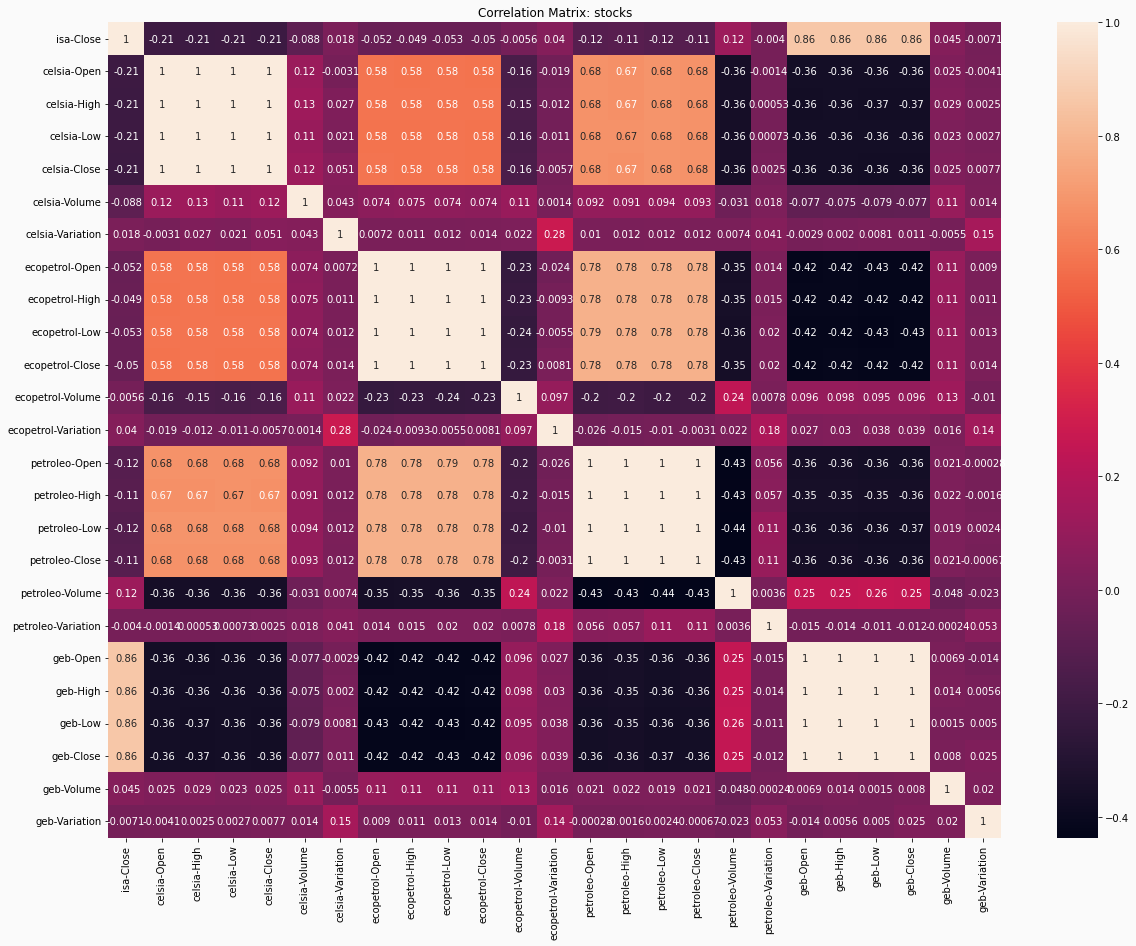

In [15]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 15), facecolor=(.98, .98, .98))
a = df_integrated_stocks.corr()
sns.heatmap(a, annot=True).set(title='Correlation Matrix: stocks');

plt.xlabel('')
plt.ylabel('')

;

According to the correlation matrix, the most important variables for the prediction of the closing price of ISA base only stocks datasets are the following prices of GEB:

- `Open`
- `High`
- `Low`
- `Close`

It can be seen that oil and Celsia's stock have a slight correlation that we will not consider relevant given a proposed threshold of |0.3|

## Correlation Matrix: TES

In [16]:
# Combine all into one dataframe; preserve every entry
lst_df = [
    df_isa[['Close']],
    df_tesone[['High', 'Low', 'Close', 'Variation']],
    df_tesfive[['Open', 'High', 'Low', 'Close', 'Variation']],
    df_tesfifteen[['High', 'Low', 'Close', 'Variation']],
];
df_integrated_tes = pd.concat(lst_df,
                          keys = ['isa', 'tesone', 'tesfive', 'tesfifteen'],
                          axis = 1,
                          join = 'outer'
                         )
df_integrated_tes.head()

isa tesone                       tesfive                       \
              Close   High  Low  Close Variation    Open   High    Low  Close   
2012-04-30  11400.0    0.0  0.0  5.819       NaN   6.277  6.277  6.277  6.277   
2012-05-02  11700.0    0.0  0.0  5.858       0.0   6.275  6.275  6.275  6.275   
2012-05-03  11760.0    0.0  0.0  5.839       0.0   6.245  6.245  6.245  6.245   
2012-05-04  11900.0    0.0  0.0  5.871       0.0   6.284  6.284  6.284  6.284   
2012-05-07  11740.0    0.0  0.0  5.854       0.0   6.283  6.283  6.283  6.283   

                     tesfifteen                          
           Variation       High    Low  Close Variation  
2012-04-30       NaN      7.330  7.330  7.330       NaN  
2012-05-02       0.0      7.326  7.326  7.326       0.0  
2012-05-03       0.0      7.260  7.260  7.260       0.0  
2012-05-04       0.0      7.248  7.248  7.248       0.0  
2012-05-07       0.0      7.250  7.250  7.250       0.0

Text(87.0, 0.5, '')

<Figure size 432x288 with 0 Axes>

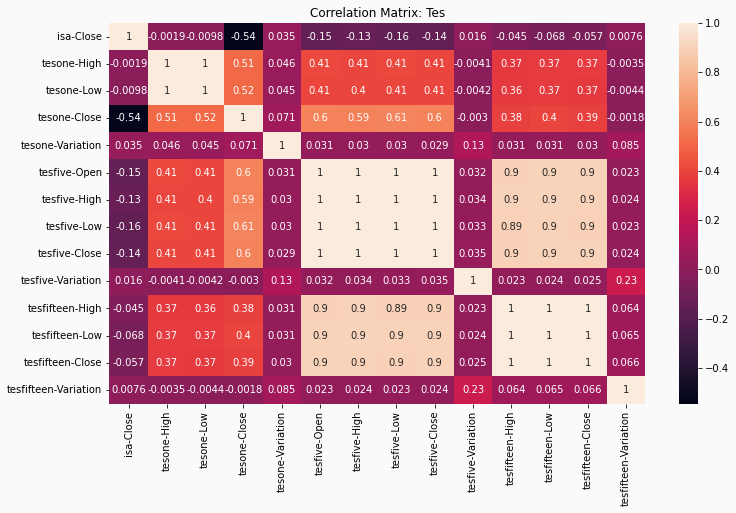

In [17]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), facecolor=(.98, .98, .98))
a = df_integrated_tes.corr()
sns.heatmap(a, annot=True).set(title='Correlation Matrix: Tes');
plt.xlabel('')
plt.ylabel('')

According to the correlation matrix, the most important variable for the prediction of the closing price of ISA base only Tes  datasets is:

**tesone**: `Close`


## Correlation Matrix: Others/Indicators

In [18]:
# Combine all into one dataframe; preserve every entry
lst_df = [
    df_isa[['Close']],
    df_embi[['Percentage Terms']],
    df_colcap[['High', 'Low', 'Close', 'Variation']],
    df_usd[['Open', 'High', 'Low', 'Close', 'Variation']],
    
    
    
]
df_integrated_others = pd.concat(lst_df,
                          keys = ['isa', 'embi', 'colcap', 'usd'],
                          axis = 1,
                          join = 'outer'
                         )
df_integrated_others.head()


isa             embi   colcap                              \
              Close Percentage Terms     High      Low    Close Variation   
2012-04-30  11400.0         1.520000  1785.66  1771.08  1785.66       NaN   
2012-05-02  11700.0         2.194722  1814.12  1796.75  1814.12  1.624650   
2012-05-03  11760.0         2.194722  1812.08  1803.19  1812.08 -0.110254   
2012-05-04  11900.0         2.194722  1806.52  1792.50  1799.25 -0.717439   
2012-05-07  11740.0         2.194722  1802.34  1788.96  1802.34  0.166759   

                usd                                       
               Open     High      Low    Close Variation  
2012-04-30  1764.05  1766.28  1760.00  1762.38       NaN  
2012-05-02  1760.50  1768.85  1751.75  1756.75 -0.340522  
2012-05-03  1756.65  1758.00  1749.00  1756.60  0.000000  
2012-05-04  1756.75  1760.20  1752.00  1757.75  0.056948  
2012-05-07  1757.10  1763.49  1751.50  1754.57 -0.170746

''

<Figure size 432x288 with 0 Axes>

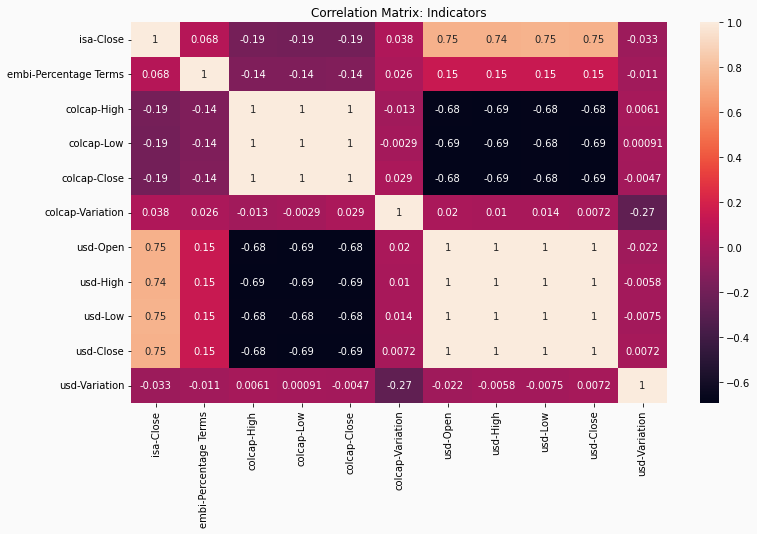

In [19]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), facecolor=(.98, .98, .98))
a = df_integrated_others.corr()
sns.heatmap(a, annot=True).set(title='Correlation Matrix: Indicators');
plt.xlabel('')
plt.ylabel('')
;

According to the correlation matrix, the most important variables for the prediction of the closing price of ISA base only Indicators  datasets are the usd prices

# Normalizing

In [20]:
#organizing data



normalized_isa = df_isa['Close'].div(df_isa['Close'].iloc[0]).mul(100)
normalized_geb = df_geb.Close.div(df_geb.Close.iloc[0]).mul(100)
normalized_ecopetrol = df_ecopetrol.Close.div(df_ecopetrol.Close.iloc[0]).mul(100)
normalized_celsia = df_celsia.Close.div(df_celsia.Close.iloc[0]).mul(100)
normalized_petroleo = df_petroleo.Close.div(df_petroleo.Close.iloc[0]).mul(100)
normalized_colcap = df_colcap['Close'].div(df_colcap['Close'].iloc[0]).mul(100)
#normalized_embi = ['Close'].div(df_embi['Close'].iloc[0]).mul(100)
normalized_usd = df_usd['Close'].div(df_usd['Close'].iloc[0]).mul(100)
normalized_tesone = df_tesone['Close'].div(df_tesone['Close'].iloc[0]).mul(100)
normalized_tesfive = df_tesfive['Close'].div(df_tesfive['Close'].iloc[0]).mul(100)
normalized_tesfifteen = df_tesfifteen['Close'].div(df_tesfifteen['Close'].iloc[0]).mul(100)





## All Variables

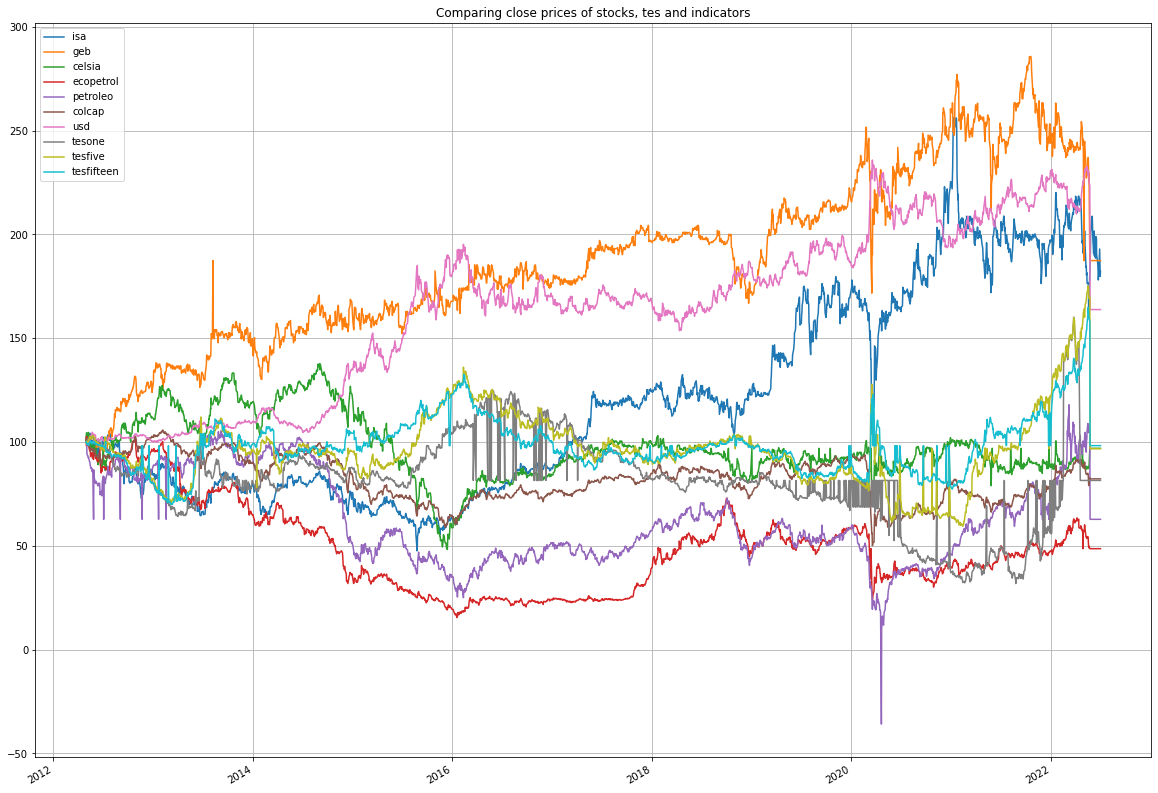

In [21]:
normalized_isa.plot(label='isa')
normalized_geb.plot(label='geb')
normalized_celsia.plot(label='celsia')
normalized_ecopetrol.plot(label='ecopetrol')
normalized_petroleo.plot(label='petroleo')
normalized_colcap.plot(label='colcap')
normalized_usd.plot(label='usd')
normalized_tesone.plot(label='tesone')
normalized_tesfive.plot(label='tesfive')
normalized_tesfifteen.plot(label='tesfifteen', grid=True)

plt.legend()
plt.title('Comparing close prices of stocks, tes and indicators')
fig = plt.gcf()
fig.set_size_inches(20, 15, forward=True)




plt.show()

## Best Correlations

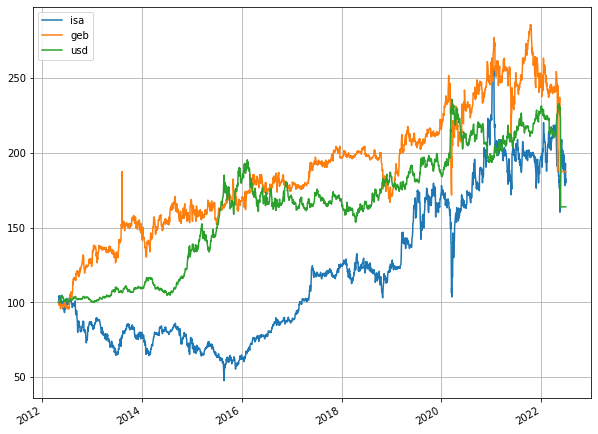

In [22]:
normalized_isa.plot(label='isa')
normalized_geb.plot(label='geb')
normalized_usd.plot(label='usd', grid=True)



plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)




plt.show()

A coherence with the findings in the correlation matrices mentioned above can be observed in the price chart. In other words, GEB and USD have a great impact on ISA's stock.

## Worst Correlations

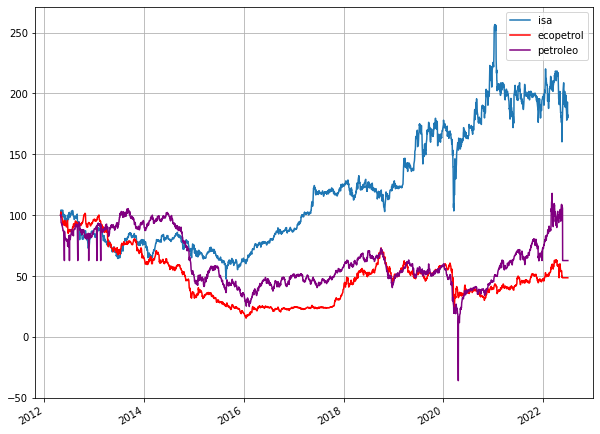

In [23]:
normalized_isa.plot(label='isa')
normalized_ecopetrol.plot(label='ecopetrol', color='red')
normalized_petroleo.plot(label='petroleo', color='purple', grid=True)


plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 8, forward=True)




plt.show()

## Final dataframe for Front

In [24]:
#could be useful for front
df_integrated.to_csv('../data/dev/Integrated.csv')

## Final dataframe for Model

In [26]:
lst_df = [df_isa[['Instrument Name', 'High', 'Mid', 'Low', 'Close', 'Volume' ]], df_geb[['Instrument Name', 'Open', 'High', 'Low', 'Close']], df_usd[['Instrument Name', 'Open', 'High', 'Low', 'Close']], df_tesone[['Instrument Name', 'Close']], df_tesfive[['Instrument Name', 'Open', 'High', 'Low', 'Close']]];
df_integrated_model = pd.concat(lst_df,
                          keys = ['isa', 'geb', 'usd', 'tesone', 'tesfive'],
                          axis = 1,
                          join = 'outer'
                         )

In [27]:
df_integrated_model.to_csv('../data/dev/df_integrated_model.csv')

## Best correlations matrix

''

<Figure size 432x288 with 0 Axes>

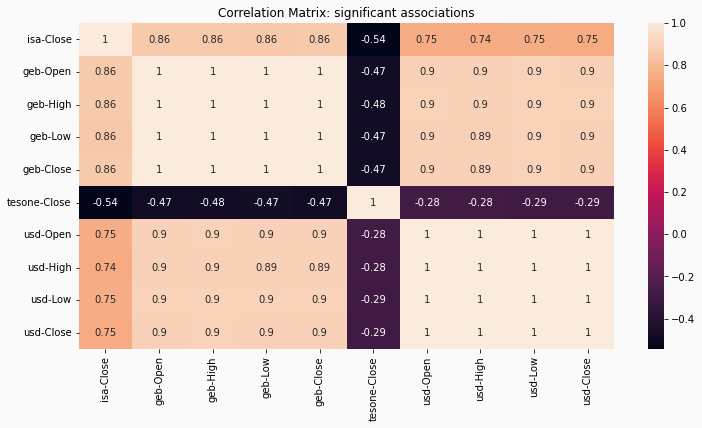

In [33]:
# correlation matrix for datafolio, contains only variables deemed impactful
# Combine all into one dataframe; preserve every entry
lst_df = [
    df_isa[['Close']],
    df_geb[['Open']],
    df_geb[['High']],
    df_geb[['Low']],
    df_geb[['Close']],
    df_tesone[['Close']],
    df_usd[['Open']],
    df_usd[['High']],
    df_usd[['Low']],
    df_usd[['Close']]
    
];

df_integrated_dfol= pd.concat(lst_df,
                          keys = ['isa', 'geb', 'geb', 'geb', 'geb', 'tesone', 'usd', 'usd', 'usd', 'usd'],
                          axis = 1,
                          join = 'outer'
                         )

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), facecolor=(.98, .98, .98))
a = df_integrated_dfol.corr()
sns.heatmap(a, annot=True).set(title='Correlation Matrix: significant associations');

plt.xlabel('')
plt.ylabel('')

;